# Fourier Feature Mapping on PytorchLightening

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input data

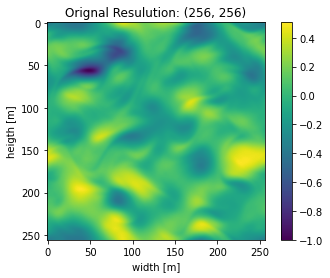

Image output parameter: 1 -> pixel intensity


In [102]:
## SET UP DATA
img_dir = '../data/DNS_Scal/'
img_name = 'Scalar_36'
img_path = img_dir + img_name
img = np.loadtxt(open(img_path, "rb"), delimiter="\t")
img = img[:,3].reshape((256,256))

# normalization
img = img / np.max(np.abs(img))

ntarget = 1
prediction = 'pixel intensity'

plt.title('Orignal Resulution: (%d, %d)' % img.shape)
plt.imshow(img)
plt.xlabel('width [m]')
plt.ylabel('heigth [m]')
plt.colorbar()
plt.show()
print('Image output parameter:', ntarget, '->', prediction)

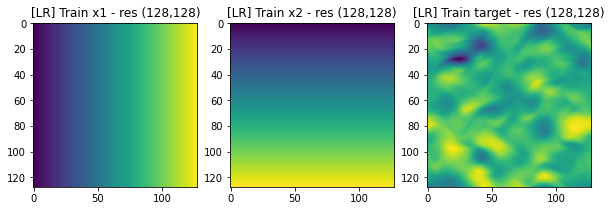

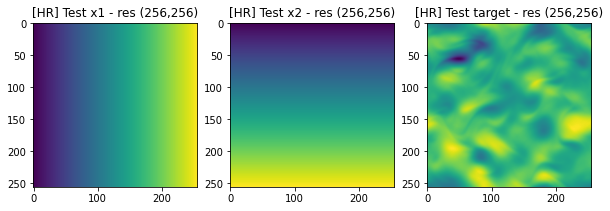

In [103]:
# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img] # full size [coords, img]

ds = 2
train_data = [x_test[::ds,::ds,:], img[::ds,::ds]] # downsampled resultion (one every 2)


plt.figure(figsize=(10,8))
plt.subplot(131)
plt.title('[LR] Train x1 - res (%d,%d)' % train_data[0][:,:,0].shape)
plt.imshow(train_data[0][:,:,0])
plt.subplot(132)
plt.title('[LR] Train x2 - res (%d,%d)' % train_data[0][:,:,1].shape)
plt.imshow(train_data[0][:,:,1])
plt.subplot(133)
plt.title('[LR] Train target - res (%d,%d)' % train_data[1].shape)
plt.imshow(train_data[1])
plt.show()

plt.figure(figsize=(10,8))
plt.subplot(131)
plt.title('[HR] Test x1 - res (%d,%d)' % test_data[0][:,:,0].shape)
plt.imshow(test_data[0][:,:,0])
plt.subplot(132)
plt.title('[HR] Test x2 - res (%d,%d)' % test_data[0][:,:,1].shape)
plt.imshow(test_data[0][:,:,1])
plt.subplot(133)
plt.title('[HR] Test target - res (%d,%d)' % test_data[1].shape)
plt.imshow(test_data[1])
plt.show()

## Fourier Features Mapping

(128, 128, 2)
(8, 2)
-94.37610645293948 117.34680120920244
(128, 128, 8)
(128, 128, 16)
Freq [82.42, 48.00]


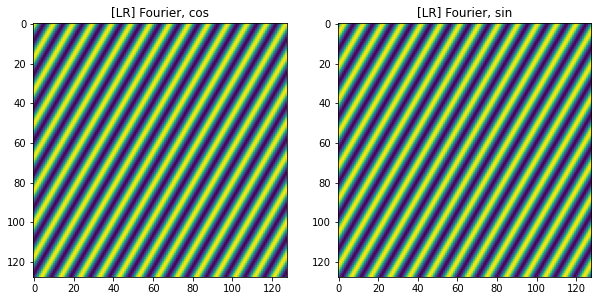

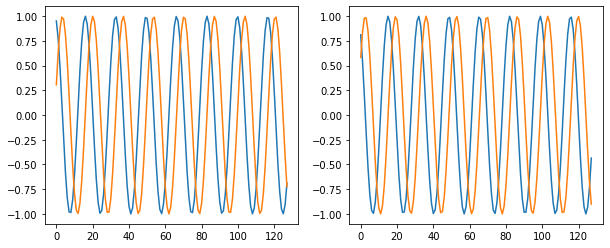

Freq [117.35, 90.90]


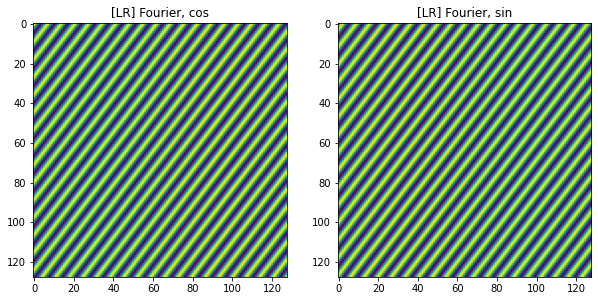

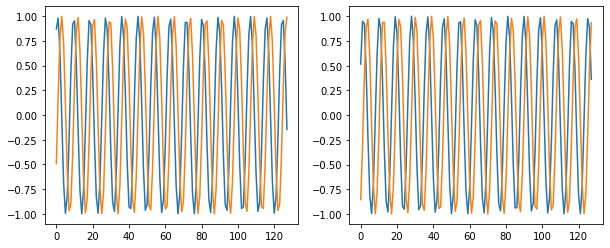

Freq [-57.17, -10.95]


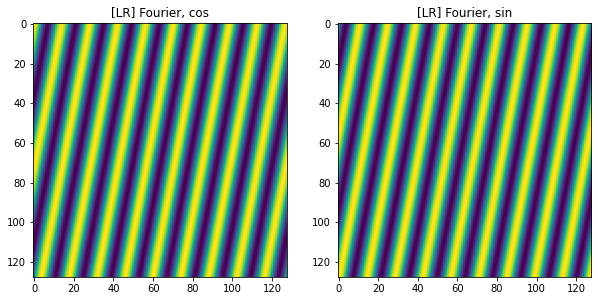

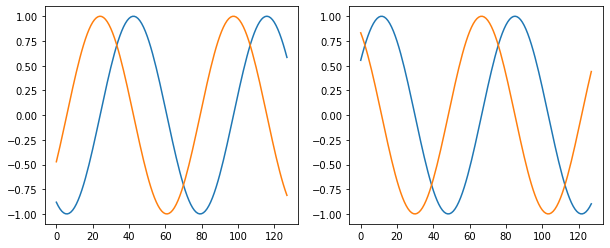

Freq [1.90, -94.38]


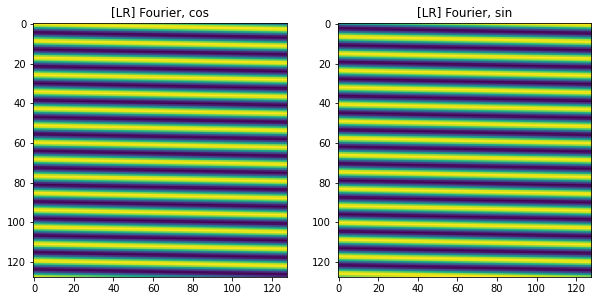

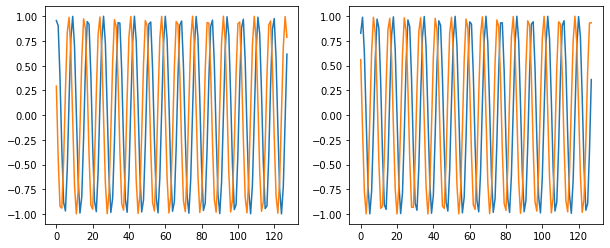

Freq [64.06, -78.64]


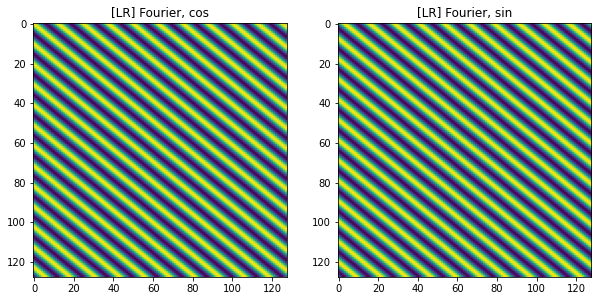

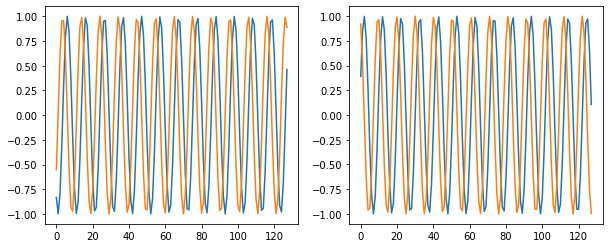

Freq [60.89, -93.10]


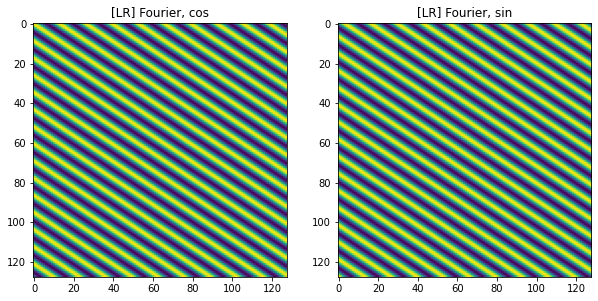

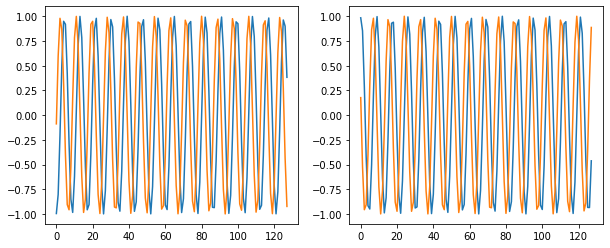

Freq [97.82, -73.69]


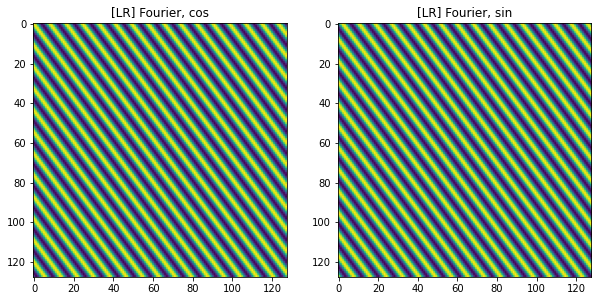

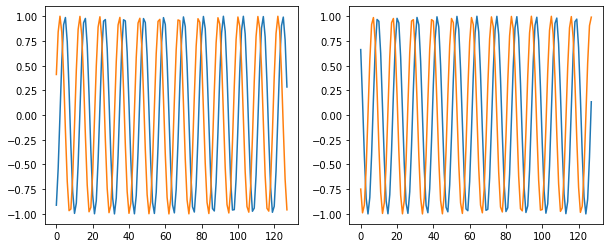

Freq [-29.87, -46.06]


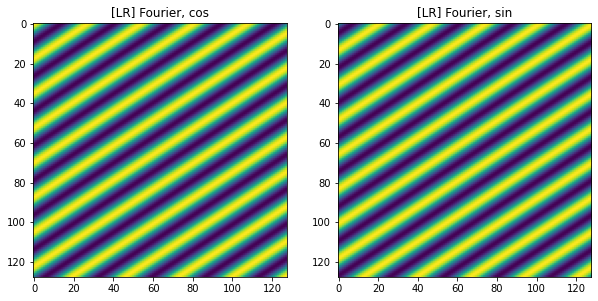

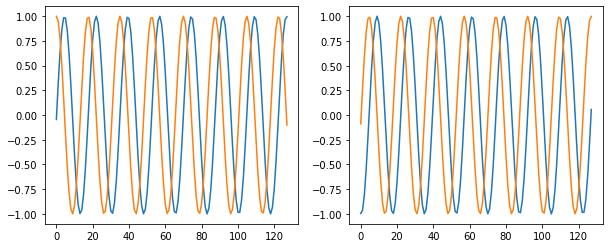

In [156]:
np.random.seed(666)

d = 2
nfeatures = 8
scale = 10
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
X = np.stack(np.meshgrid(coords, coords), -1)[::ds, ::ds, :]

print(X.shape)

B = np.random.normal(0, scale**2, size=(nfeatures,d))
print(B.shape)
print(np.min(B), np.max(B))

# RFF mapping
freqs = X @ B.T
print(freqs.shape)
F = np.concatenate([np.cos(freqs), np.sin(freqs)], axis=-1)
print(F.shape)

for i in range(nfeatures):
    
    print('Freq [%1.2f, %1.2f]' % (B[i,0],B[i,1]) )
    plt.figure(figsize=(10,8))
    plt.subplot(121)
    plt.title('[LR] Fourier, cos')
    plt.imshow(F[:,:,i])
    plt.subplot(122)
    plt.title('[LR] Fourier, sin')
    plt.imshow(F[:,:,nfeatures+i])
    plt.show()
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(F[:,20,i])
    plt.plot(F[:,20,nfeatures+i])
    plt.subplot(122)
    plt.plot(F[:,40,i])
    plt.plot(F[:,40,nfeatures+i])
    plt.show()
    

## Harmonic wavelets basis

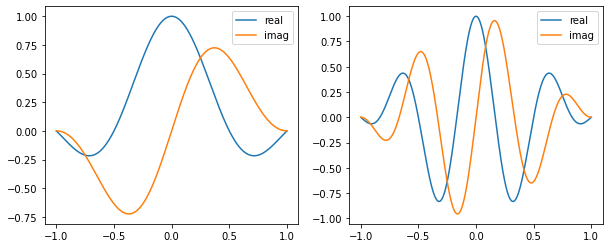

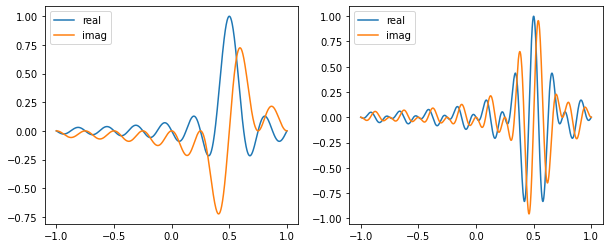

In [179]:
phi = lambda x : (np.exp(1j*2*np.pi*x) - 1)/(1j*2*np.pi*x)
psi = lambda x : np.exp(1j*2*np.pi*x)*phi(x)

t = np.linspace(-1, 1, 1000)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(t, np.real(phi(t)), label='real')
plt.plot(t, np.imag(phi(t)), label='imag')
plt.legend()
plt.subplot(122)
plt.plot(t, np.real(psi(t)), label='real')
plt.plot(t, np.imag(psi(t)), label='imag')
plt.legend()
plt.show()

def phi_nk(x, n : int, k : int):
    # n the scale
    # k the location
    arg = 1j*2*np.pi*((2**n)*x - k)
    tmp = (2**(n/2))*(np.exp(arg) - 1)/arg
    return tmp / np.max(np.abs(tmp))

def psi_nk(x, n : int, k : int):
    # n the scale
    # k the location
    arg = 1j*2*np.pi*((2**n)*x - k)
    tmp = (2**(n/2))*(np.exp(2*arg) - np.exp(arg))/arg
    return tmp / np.max(np.abs(tmp))

t = np.linspace(-1, 1, 1000)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(t, np.real(phi_nk(t, 2, 2)), label='real')
plt.plot(t, np.imag(phi_nk(t, 2, 2)), label='imag')
plt.legend()
plt.subplot(122)
plt.plot(t, np.real(psi_nk(t, 2, 2)), label='real')
plt.plot(t, np.imag(psi_nk(t, 2, 2)), label='imag')
plt.legend()
plt.show()

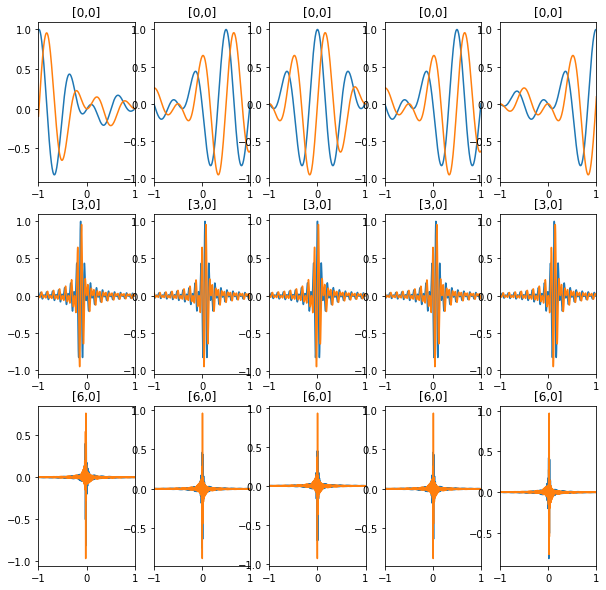

In [199]:
t = np.linspace(-1, 1, 500)
ngrid = [0, 3, 6] # scale
kgrid = [-0.99, 0.5, 0, 0.5, 0.99] # translation

fig, axarr = plt.subplots(len(ngrid), len(kgrid), figsize=(10,10))
for k, kk in enumerate(kgrid):
    for n, nn in enumerate(ngrid):
        axarr[n,k].plot(t, np.real(psi_nk(t, nn, kk)), label='real')
        axarr[n,k].plot(t, np.imag(psi_nk(t, nn, kk)), label='imag')
        axarr[n,k].set_xlim((-1,1))
        axarr[n,k].set_title('[%d,%d]' % (nn,kk))
        
plt.show()

In [170]:
def PHI_nk(X, B, N, K):
    arg = 1j*2*np.pi*((2**N)*X @ B - K)
    return (2**(N/2))*(np.exp(arg) - 1)/arg

def PSI_nk(X, B, N, K):
    arg = 1j*2*np.pi*((2**n)*X @ B.T - K)
    return (2**(N/2))*(np.exp(2*arg) - np.exp(arg))/arg

nfeatures = 4

coords = np.linspace(0, 1, img.shape[0], endpoint=False)
X = np.stack(np.meshgrid(coords, coords), -1)[::ds, ::ds, :]
d = X.shape[-1]

print(X.shape)
B = B = np.random.uniform(-1, 1, size=(nfeatures,d))
print(B.shape)

N = np.arange()
B = np.random.randint(nfeatures)

(128, 128, 2)
(4, 2)
